In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!mkdir ~/.kaggle

!cp drive/MyDrive/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle datasets download -d andrewmvd/cyberbullying-classification

!unzip cyberbullying-classification.zip

cyberbullying-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cyberbullying-classification.zip
replace cyberbullying_tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cyberbullying_tweets.csv  


In [3]:
!pip install -q git+https://github.com/gmihaila/ml_things.git

!pip install -q git+https://github.com/huggingface/transformers.git

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import io
import os
import torch
import pandas as pd
from numpy.random import RandomState
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)


set_seed(456)

epochs = 8

batch_size = 32

max_length = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name_or_path = 'gpt2'

labels_ids = {'religion': 0, 'age': 1, 'gender': 2, 'ethnicity': 3, 'not_cyberbullying': 4, 'other_cyberbullying': 5}

n_labels = len(labels_ids)

In [5]:
class CyberbullyingDataset(Dataset):

  def __init__(self, df, use_tokenizer):

    self.texts = df['tweet_text'].tolist()
    self.labels = df['cyberbullying_type'].tolist()

    for text in self.texts:
      text = fix_text(text)

    print(self.texts)
    print(self.labels)

    self.n_examples = len(self.labels)
    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder
        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})
        return inputs



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def train(dataloader, optimizer_, scheduler_, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.train()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)
    loss, logits = outputs[:2]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer_.step()
    scheduler_.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
  avg_epoch_loss = total_loss / len(dataloader)
  return true_labels, predictions_labels, avg_epoch_loss

def validation(dataloader, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.eval()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content
  avg_epoch_loss = total_loss / len(dataloader)
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
print('Loading configuration...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuration...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [7]:
df = pd.read_csv('/content/cyberbullying_tweets.csv')
rng = RandomState()

train = df.sample(frac=0.7, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

print('Dealing with Train...')
train_dataset = CyberbullyingDataset(df=train, 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))  
print()
print('Dealing with Validation...')
valid_dataset =  CyberbullyingDataset(df=test, 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                              collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Output hidden; open in https://colab.research.google.com to view.

Epoch


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/8 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.90730 - val_loss: 0.74129 - train_acc: 0.63641 - valid_acc: 0.71401


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.62889 - val_loss: 0.63538 - train_acc: 0.74419 - valid_acc: 0.74343


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.58114 - val_loss: 0.66281 - train_acc: 0.76318 - valid_acc: 0.74063


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.84138 - val_loss: 1.11764 - train_acc: 0.69743 - valid_acc: 0.56856


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.82062 - val_loss: 0.68623 - train_acc: 0.69533 - valid_acc: 0.74287


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.59255 - val_loss: 0.68338 - train_acc: 0.76033 - valid_acc: 0.74154


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.57043 - val_loss: 0.64582 - train_acc: 0.76959 - valid_acc: 0.74923


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.56420 - val_loss: 0.65069 - train_acc: 0.77235 - valid_acc: 0.74979



/usr/local/lib/python3.9/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


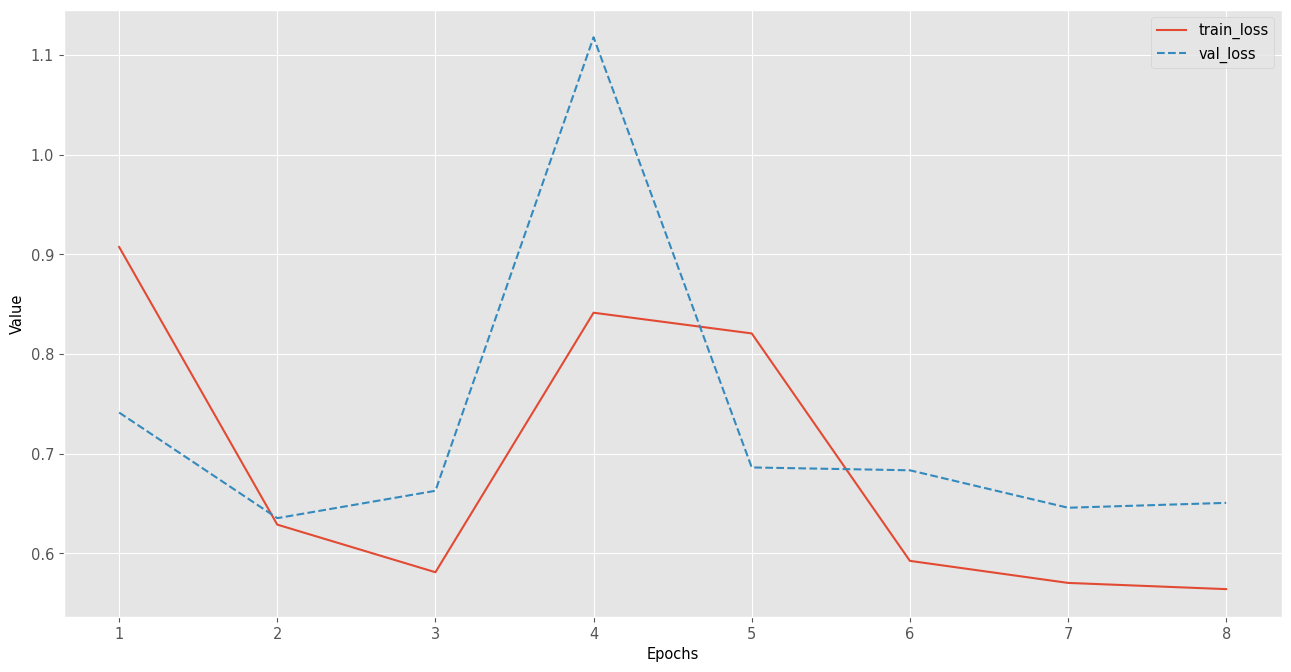

/usr/local/lib/python3.9/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


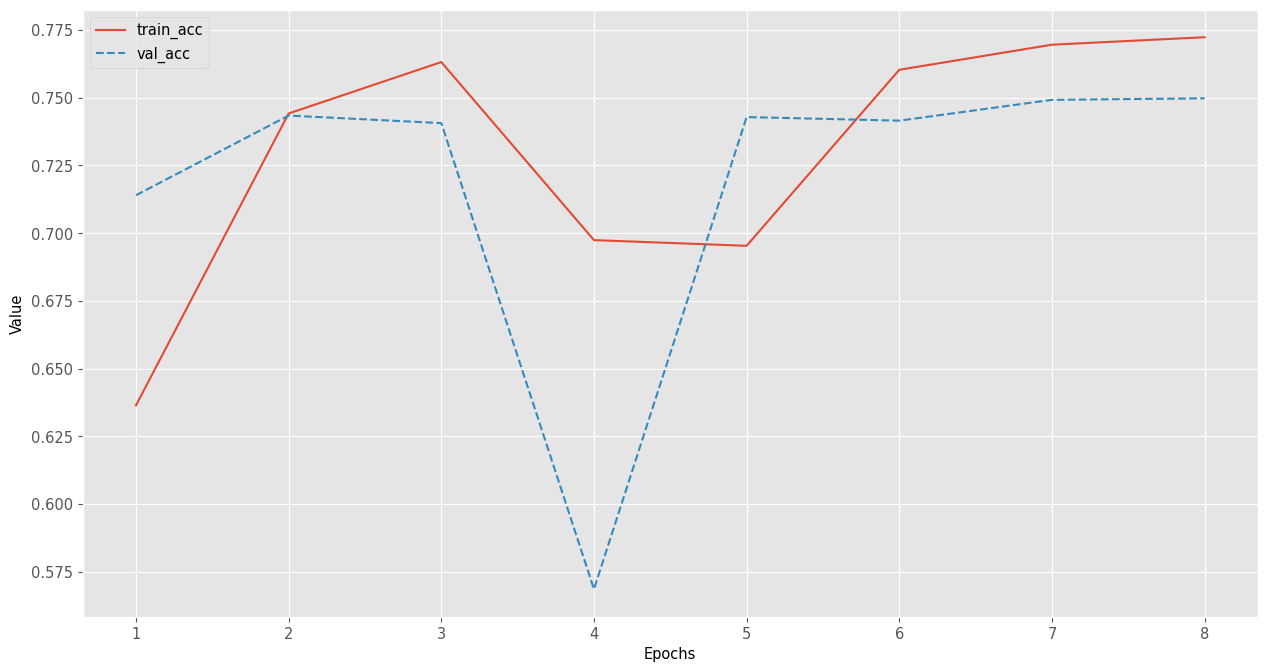

In [13]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                  )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/448 [00:00<?, ?it/s]

Accuracy: 74.98%
                     precision    recall  f1-score   support

           religion       0.83      0.91      0.87      2422
                age       0.90      0.90      0.90      2312
             gender       0.74      0.77      0.75      2402
          ethnicity       0.85      0.87      0.86      2472
  not_cyberbullying       0.61      0.40      0.48      2376
other_cyberbullying       0.55      0.65      0.59      2324

           accuracy                           0.75     14308
          macro avg       0.75      0.75      0.74     14308
       weighted avg       0.75      0.75      0.74     14308

Normalized confusion matrix


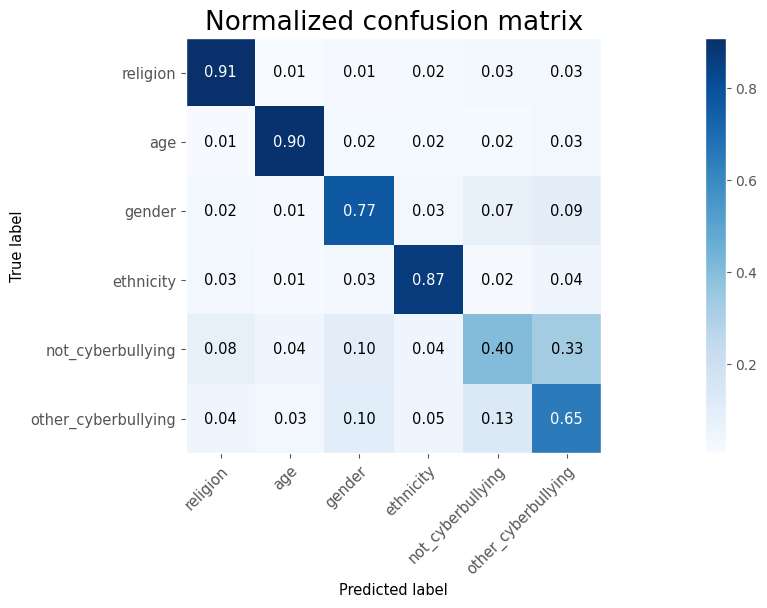

In [14]:
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

acc = accuracy_score(true_labels, predictions_labels) * 100
print("Accuracy: %.2f%%" % (acc))

evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );